In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.evaluate import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from useful_tools import df_features_preanalysis, features_visualization, features_correlations, plot_model_comparison

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

from typing import Tuple
import math 

# About Dataset

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Link to this Kaggle dataset [here](https://www.kaggle.com/datasets/uciml/adult-census-income).

### The prediction task is to determine whether a person makes over $50K a year

In [2]:
# Read data file
df = pd.read_csv('../data/data_assignment_3.csv', na_values='?')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df_features_preanalysis(df)

──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
GENERAL INFO
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
The original dataset has 32,561 rows and 15 columns, with a total of 4262 NaN values and 24 rows repeated
· Statistical info about the numerical features


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


None
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FEATURES INFO
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
------------------------------------|   FEATURE 0: age   |------------------------------------
<class 'int'>    32561
Name: age, dtype: int64

The first ten unique elements are:
90
82
66
54
41
34
38
74
68
...
In this column there are 73 unique values and 0 NaN values

------------------------------------|   FEATURE 1: workclass   |------------------------------------
<class 'str'>      30725
<class 'float'>     1836
Name: workclass, dtype: int64

In this column there are 9 unique values and 1836 NaN values:
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
NaN                  1836
State-gov            1298
Self-emp-inc         1116
Federal-go

In [4]:
# Obtain a clean version of the raw data
df_clean = df.dropna().reset_index(drop=True)
# Remove repeated rows
df_clean = df_clean.drop_duplicates(keep='first')
# Replace labels as 0 and 1, being 1 the rare event
df_clean['income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)

In [5]:
df_clean.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0


## Features visualization

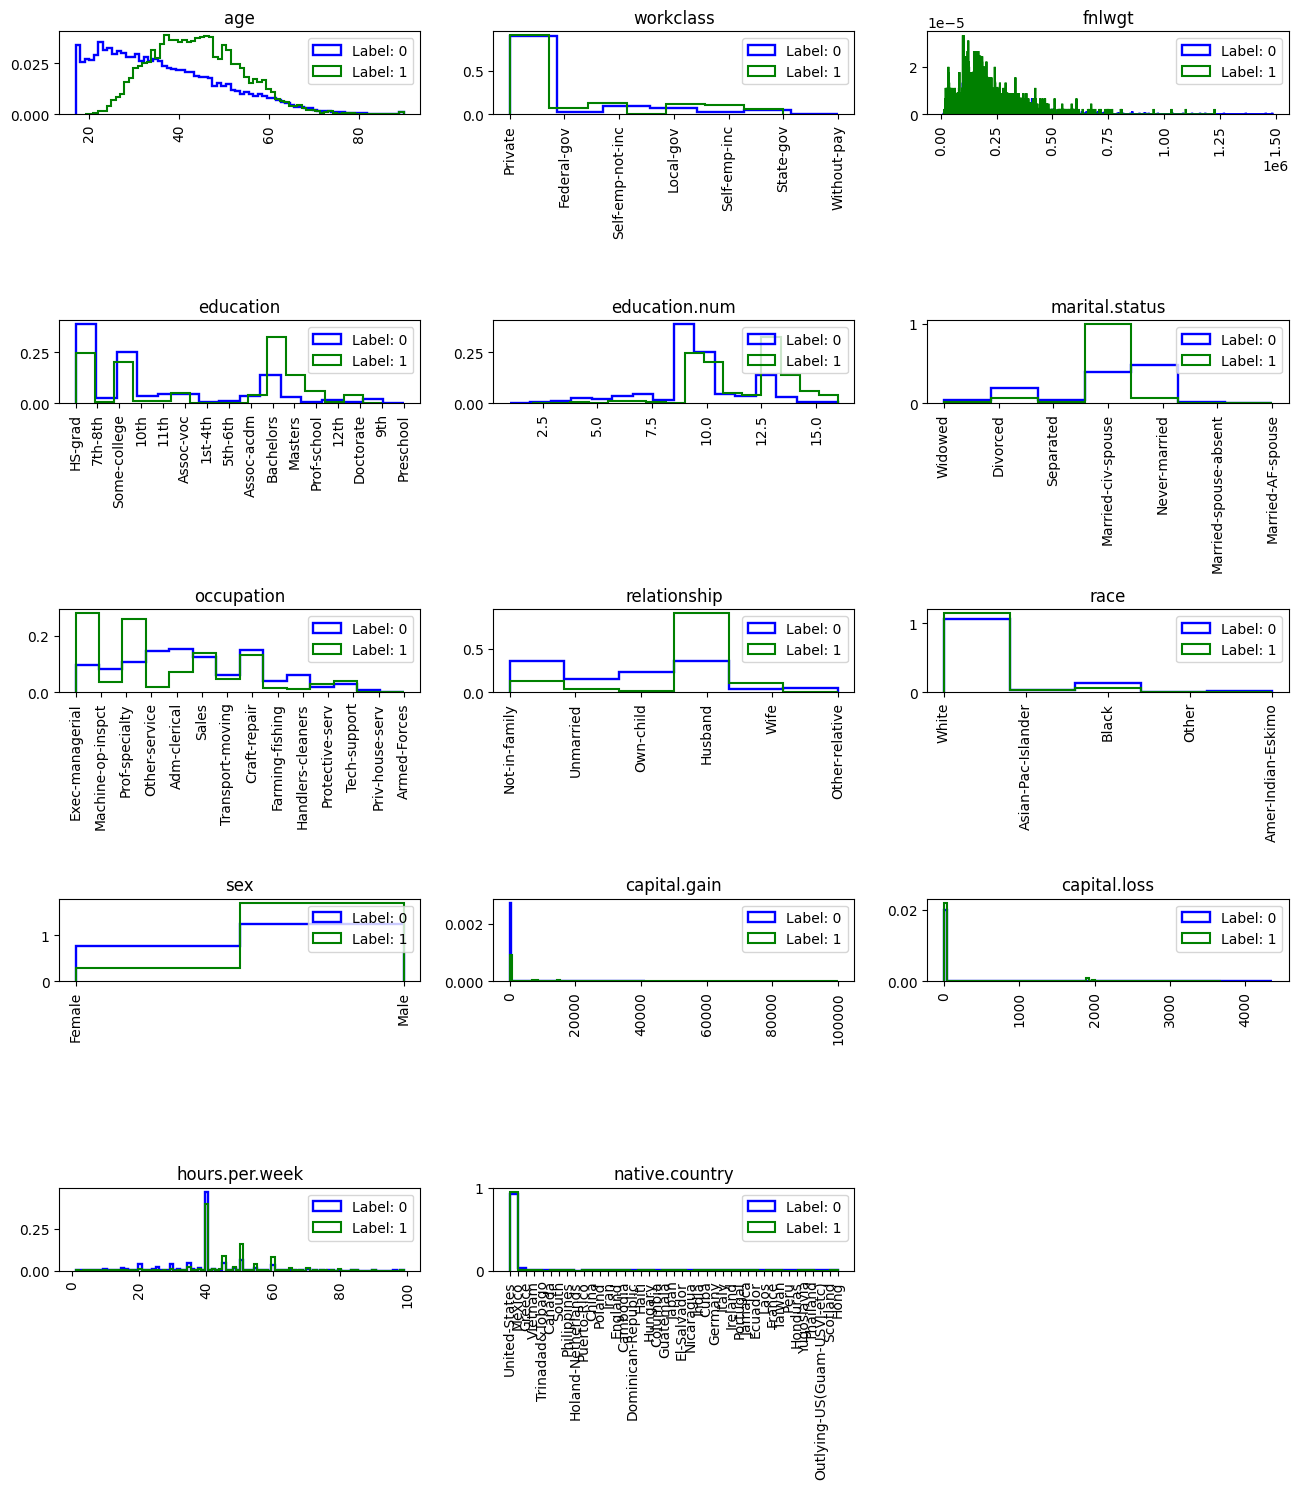

In [6]:
features_visualization(df_clean, 'income', (0, 1))

### Let's reduce the cardinality in those features in which it is evident that we can aisolate the value of the mayority and combining all other values together

Native country:

ORIGINAL FEATURE UNIQUE VALUES


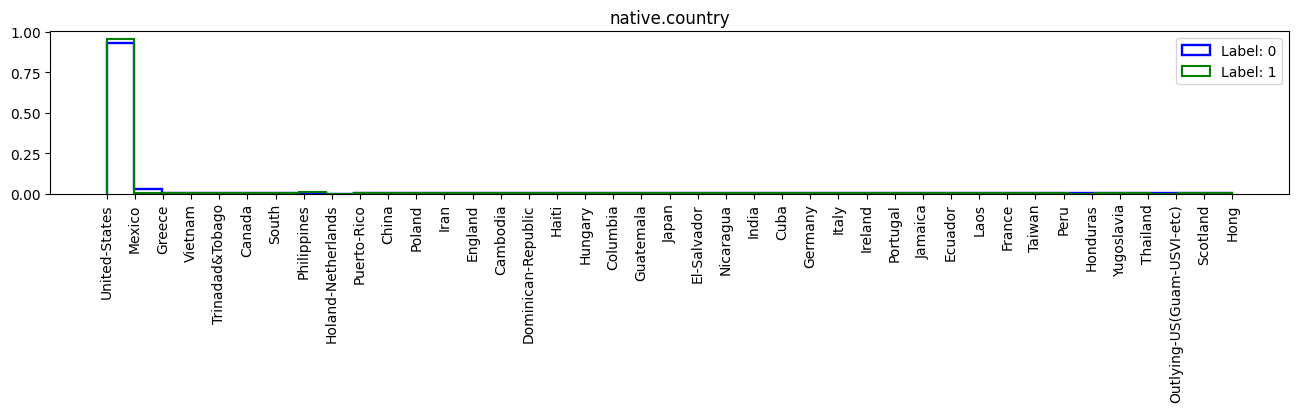

NEW FEATURE UNIQUE VALUES


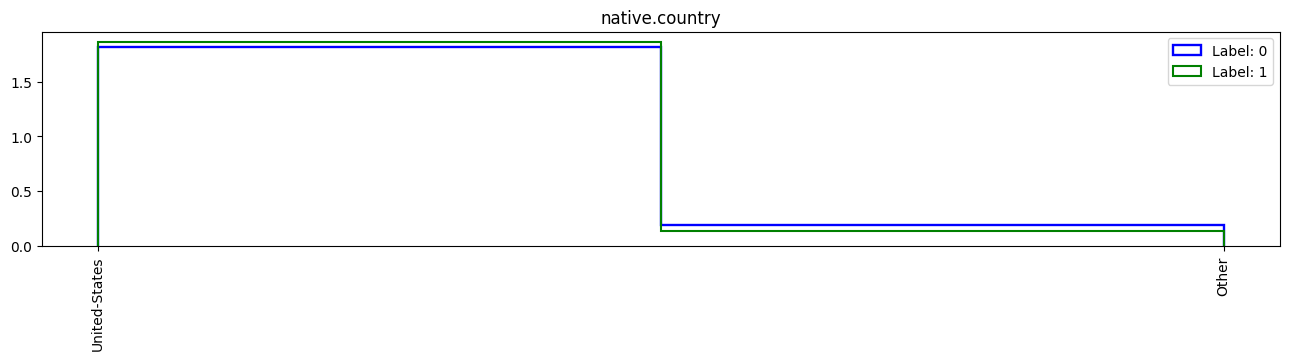

In [7]:
# Plot original feature distribution
print('ORIGINAL FEATURE UNIQUE VALUES')
features_visualization(df_clean[['native.country', 'income']], 'income', (0, 1), num_plot_columns=1)

# Extract all unique values except the one of the mayority
other_values = df_clean['native.country'].unique().tolist()
other_values.remove('United-States')

# Combine them in 'Other' value
df_clean['native.country'].replace(other_values, 'Other', inplace = True)

# Plot new feature distribution
print('NEW FEATURE UNIQUE VALUES')
features_visualization(df_clean[['native.country', 'income']], 'income', (0, 1), num_plot_columns=1)

Capital gain

ORIGINAL FEATURE UNIQUE VALUES


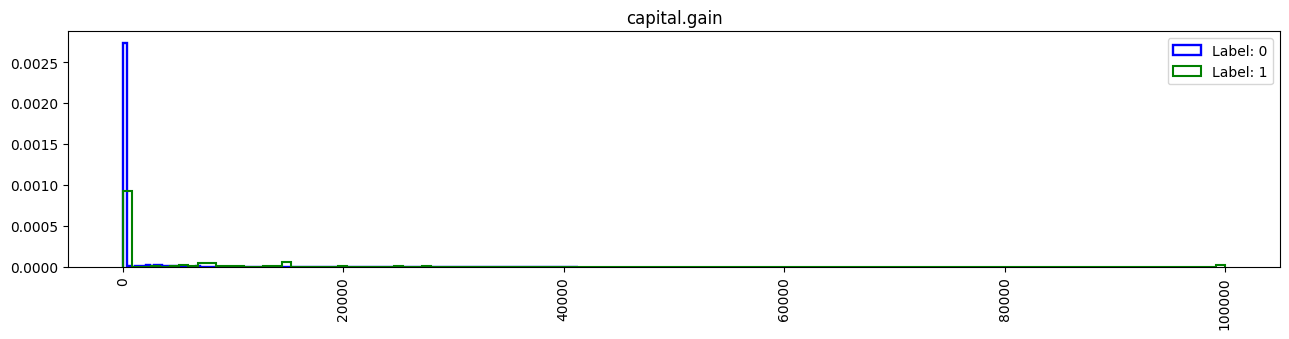

NEW FEATURE UNIQUE VALUES


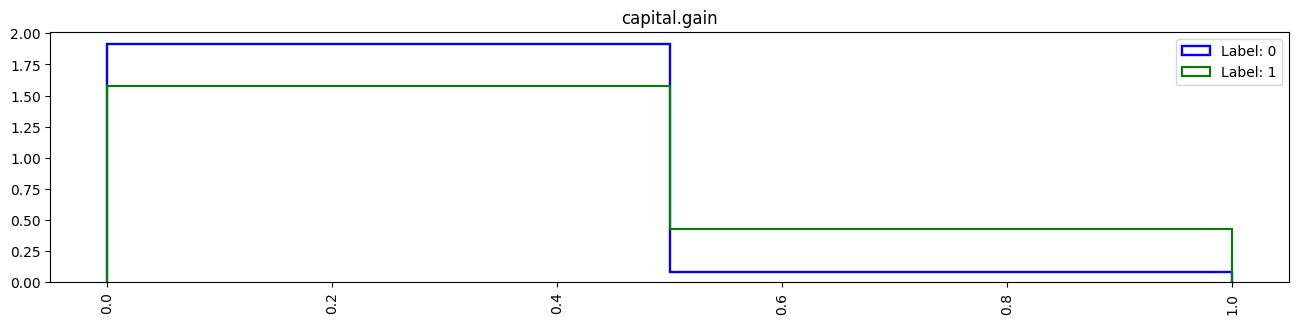

In [8]:
# Plot original feature distribution
print('ORIGINAL FEATURE UNIQUE VALUES')
features_visualization(df_clean[['capital.gain', 'income']], 'income', (0, 1), num_plot_columns=1)

# Extract all unique values except the one of the mayority
other_values = df_clean['capital.gain'].unique().tolist()
other_values.remove(0)

# Combine them in 'Other' value
df_clean['capital.gain'].replace(other_values, 1, inplace = True)

# Plot new feature distribution
print('NEW FEATURE UNIQUE VALUES')
features_visualization(df_clean[['capital.gain', 'income']], 'income', (0, 1), num_plot_columns=1)

Capital loss

ORIGINAL FEATURE UNIQUE VALUES


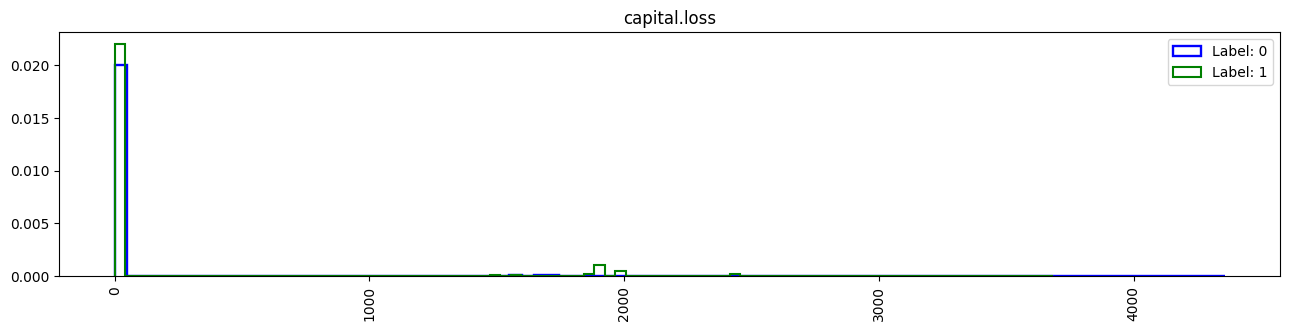

NEW FEATURE UNIQUE VALUES


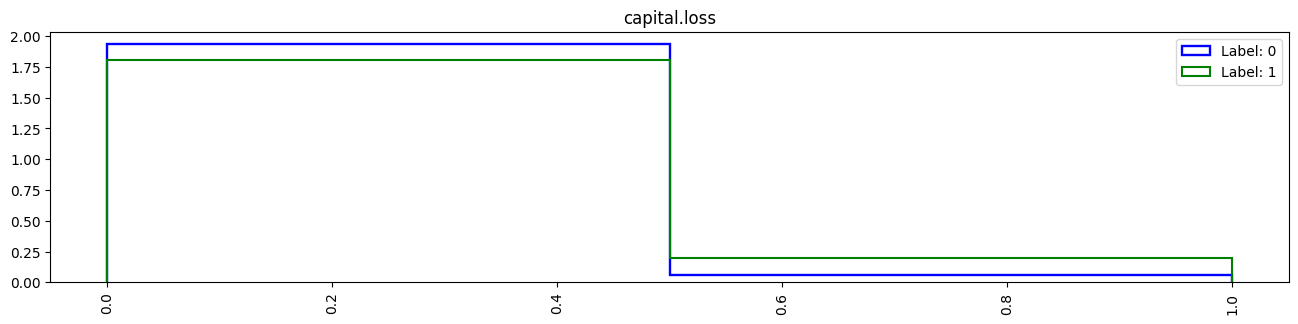

In [9]:
# Plot original feature distribution
print('ORIGINAL FEATURE UNIQUE VALUES')
features_visualization(df_clean[['capital.loss', 'income']], 'income', (0, 1), num_plot_columns=1)

# Extract all unique values except the one of the mayority
other_values = df_clean['capital.loss'].unique().tolist()
other_values.remove(0)

# Combine them in 'Other' value
df_clean['capital.loss'].replace(other_values, 1, inplace = True)

# Plot new feature distribution
print('NEW FEATURE UNIQUE VALUES')
features_visualization(df_clean[['capital.loss', 'income']], 'income', (0, 1), num_plot_columns=1)

Race

ORIGINAL FEATURE UNIQUE VALUES


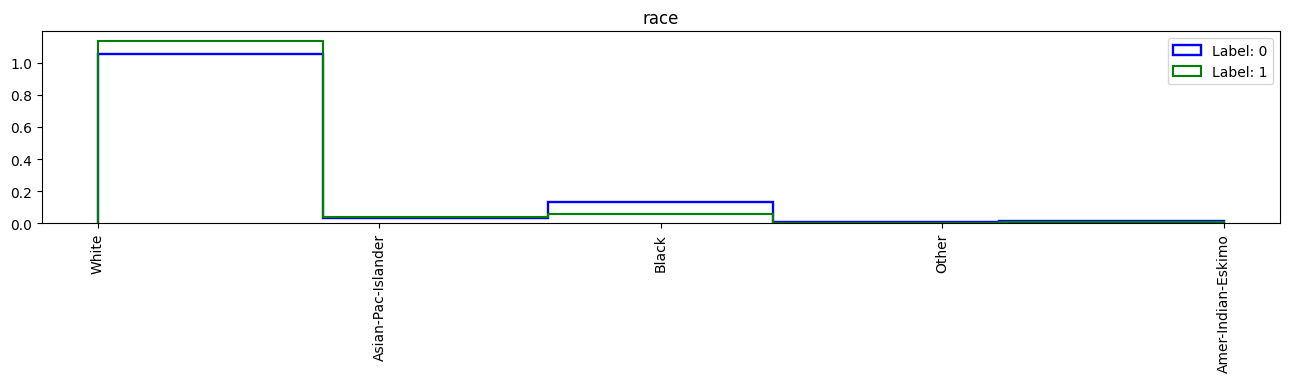

NEW FEATURE UNIQUE VALUES


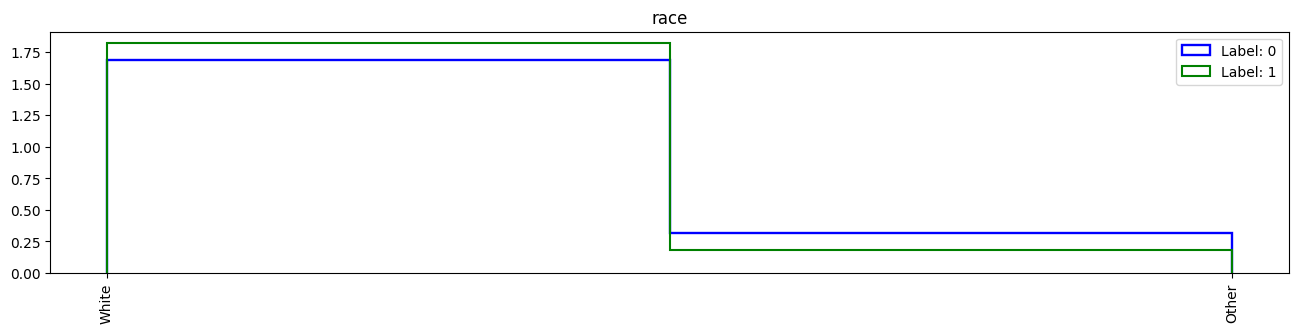

In [10]:
# Plot original feature distribution
print('ORIGINAL FEATURE UNIQUE VALUES')
features_visualization(df_clean[['race', 'income']], 'income', (0, 1), num_plot_columns=1)

# Extract all unique values except the one of the mayority
other_values = df_clean['race'].unique().tolist()
other_values.remove('White')

# Combine them in 'Other' value
df_clean['race'].replace(other_values, 'Other', inplace = True)

# Plot new feature distribution
print('NEW FEATURE UNIQUE VALUES')
features_visualization(df_clean[['race', 'income']], 'income', (0, 1), num_plot_columns=1)

### Correlations visualization

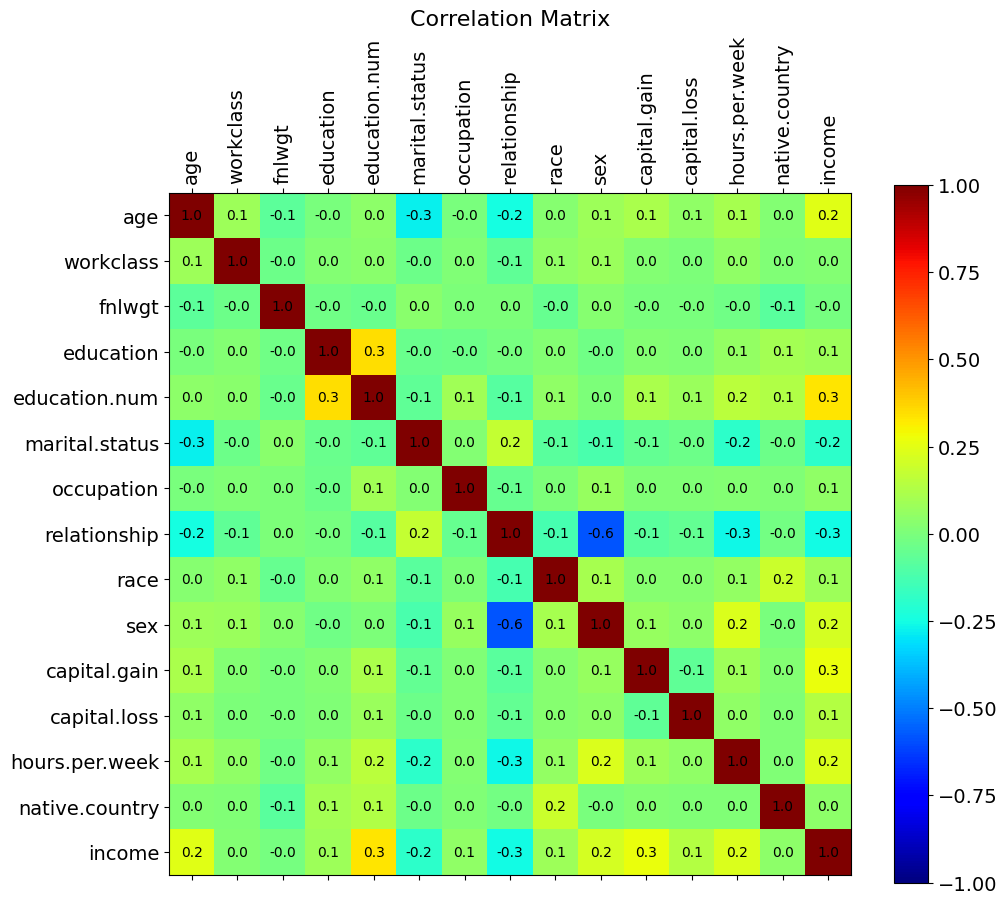

In [11]:
features_correlations(df_clean, 'income')

### Finally, we create the dataset we are going to work with during the classification

First, we extract all the features by type. We do __not include those features that are not correlated__ at all with the label, identified in the correlation matrix ('workclass', 'fnlwgt', and 'native.country')

In [12]:
# Columns that contain categorical and numerical features
cat_features_colname = ['education', 'marital.status', 'occupation', 'relationship', 'race', 'sex']

num_features_colname = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

# Label that indicates whether a person makes over $50K a year
result_label = ['income']

Construct new dataframe

In [13]:
# Define new dataframe with all features
data_features_cat = df_clean[cat_features_colname].copy(deep=True).astype(str)
data_features_num = df_clean[num_features_colname].copy(deep=True).astype(float)

# Define new dataframe with the process labels
data_labels = df_clean[result_label].copy(deep=True).astype(int)

print(f'Number of categorical features: {data_features_cat.shape[1]}')
print(f'Number of numerical features: {data_features_num.shape[1]}')
print(f'Number of labels: {data_labels.shape[1]}')

Number of categorical features: 6
Number of numerical features: 5
Number of labels: 1


In [14]:
# Concatenate the datasets with categorical and numerical features
df_org = pd.concat([data_features_cat, data_features_num, data_labels], axis=1)

Analyse how balanced the final dataset is

In [15]:
# Count 1 events in cleaned dateset
rare_events_count = df_org.loc[df_org['income'] == 1].shape[0]
background_count = df_org.shape[0] - rare_events_count

# Check 0 and 1 banlance
print(f'<=50K income:  {background_count:>7}  |  {background_count / (background_count + rare_events_count) * 100:>7.2f} % of the dataset')
print(f'>50K income:   {rare_events_count:>7}  |  {rare_events_count / (background_count + rare_events_count) * 100:>7.2f} % of the dataset')

<=50K income:    22633  |    75.10 % of the dataset
>50K income:      7506  |    24.90 % of the dataset


## Classification

First, we divide the clean data between the labels vector 'y' and the features matrix 'X'

In [16]:
y = df_org[result_label[0]]

X = df_org[cat_features_colname + num_features_colname]

### Construct a complete pipeline: data encoder + classifier

#### __Data encoder__: Transform categorical (with the [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)) values and numerical (with the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) values

In [17]:
categorical_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist')
numerical_scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features_colname),
        ('num', numerical_scaler, num_features_colname)
    ]
)

#### __Classifiers__: [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), and [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [18]:
rf_classifier = RandomForestClassifier(n_estimators=100,
                                       random_state=42)

In [19]:
dt_classifier = DecisionTreeClassifier()

In [20]:
svc_classifier = SVC()

#### __Complete pipelines__

In [21]:
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_classifier)])

In [22]:
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', dt_classifier)])

In [23]:
svc_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', svc_classifier)])

#### __Data splitting in train and test sub-datasets__

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

### Training

#### K-fold cross-validation results for each algorithm in the training set

The idea of k-fold validation is explained [here](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation_with_validation_and_test_set), based on partitioning of the training set into a training and validation subsets.

In [25]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [26]:
# RF evaluation
rf_scores = cross_validate(rf_pipe, X_train, Y_train, scoring=('precision', 'recall', 'f1'), cv=cv)
rf_y_pred = cross_val_predict(rf_pipe, X_train, Y_train, cv=cv)
rf_confusion_matrix = confusion_matrix(Y_train, rf_y_pred)

Averaged precision: 0.646 (0.010)
Averaged recall: 0.582 (0.016)
Averaged f1 score: 0.612 (0.011)
Averaged confusion matrix:


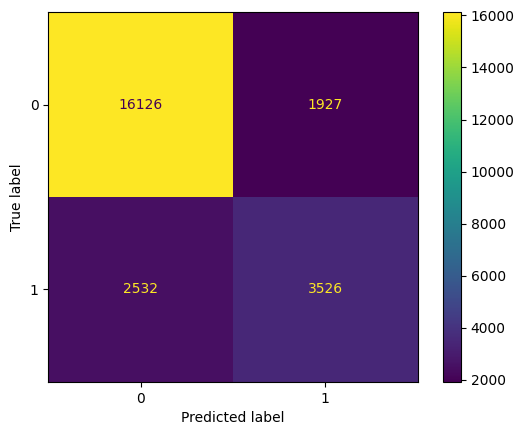

In [27]:
print('Averaged precision: %.3f (%.3f)' % (np.mean(rf_scores['test_precision']), np.std(rf_scores['test_precision'])))
print('Averaged recall: %.3f (%.3f)' % (np.mean(rf_scores['test_recall']), np.std(rf_scores['test_recall'])))
print('Averaged f1 score: %.3f (%.3f)' % (np.mean(rf_scores['test_f1']), np.std(rf_scores['test_f1'])))

print('Averaged confusion matrix:')
display_cm = ConfusionMatrixDisplay(rf_confusion_matrix).plot()

In [28]:
# DT evaluation
dt_scores = cross_validate(dt_pipe, X_train, Y_train, scoring=('precision', 'recall', 'f1'), cv=cv)
dt_y_pred = cross_val_predict(dt_pipe, X_train, Y_train, cv=cv)
dt_confusion_matrix = confusion_matrix(Y_train, dt_y_pred)

Averaged Precision: 0.578 (0.009)
Averaged Recall: 0.552 (0.007)
Averaged F1 score: 0.565 (0.004)
Averaged Confusion matrix:


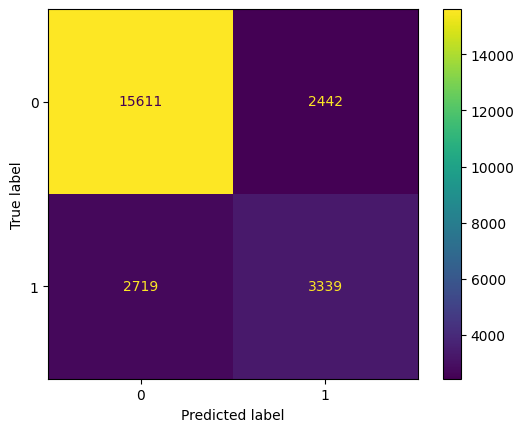

In [29]:
print('Averaged Precision: %.3f (%.3f)' % (np.mean(dt_scores['test_precision']), np.std(dt_scores['test_precision'])))
print('Averaged Recall: %.3f (%.3f)' % (np.mean(dt_scores['test_recall']), np.std(dt_scores['test_recall'])))
print('Averaged F1 score: %.3f (%.3f)' % (np.mean(dt_scores['test_f1']), np.std(dt_scores['test_f1'])))

print('Averaged Confusion matrix:')
display_cm = ConfusionMatrixDisplay(dt_confusion_matrix).plot()

In [30]:
# SVC evaluation
svc_scores = cross_validate(svc_pipe, X_train, Y_train, scoring=('precision', 'recall', 'f1'), cv=cv)
svc_y_pred = cross_val_predict(svc_pipe, X_train, Y_train, cv=cv)
svc_confusion_matrix = confusion_matrix(Y_train, svc_y_pred)

#print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print(svc_scores)
print(svc_confusion_matrix)

{'fit_time': array([10.30962849,  9.6276567 ,  9.3739953 ,  9.45840812,  9.30282688]), 'score_time': array([1.275769  , 1.26241159, 1.31942797, 2.47109461, 1.20709729]), 'test_precision': array([0.69687163, 0.7327044 , 0.7244898 , 0.74599787, 0.73908629]), 'test_recall': array([0.54792197, 0.59337861, 0.57443366, 0.57960199, 0.5782367 ]), 'test_f1': array([0.61348528, 0.65572233, 0.64079422, 0.65235651, 0.64884135])}
[[16752  1301]
 [ 2576  3482]]


Averaged Precision: 0.728 (0.017)
Averaged Recall: 0.575 (0.015)
Averaged F1 score: 0.642 (0.015)
Averaged Confusion matrix:


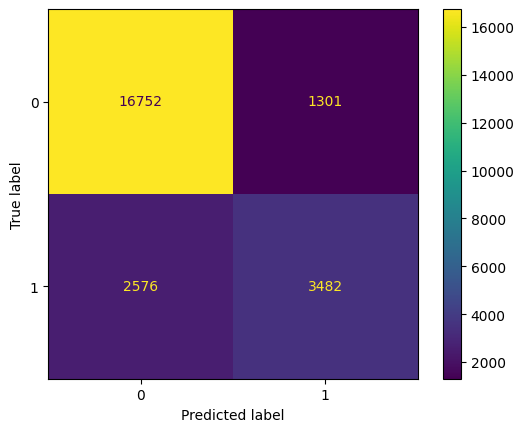

In [31]:
print('Averaged Precision: %.3f (%.3f)' % (np.mean(svc_scores['test_precision']), np.std(svc_scores['test_precision'])))
print('Averaged Recall: %.3f (%.3f)' % (np.mean(svc_scores['test_recall']), np.std(svc_scores['test_recall'])))
print('Averaged F1 score: %.3f (%.3f)' % (np.mean(svc_scores['test_f1']), np.std(svc_scores['test_f1'])))

print('Averaged Confusion matrix:')
display_cm = ConfusionMatrixDisplay(svc_confusion_matrix).plot()

### Test

K-fold is generally used to decide which model to use. However, for this assignment we will test all the models.

To do so, we first fit training sets with each model

In [32]:
rf_pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [33]:
dt_pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week'])])),
                ('classifier', DecisionTreeClassifier())])

In [34]:
svc_pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week'])])),
                ('classifier', SVC())])

And now we test the models:

In [35]:
rf_Y_pred = rf_pipe.predict(X_test)
rf_f1_test = f1_score(Y_test, rf_Y_pred)
rf_precision_test = precision_score(Y_test, rf_Y_pred)
rf_recall_test = recall_score(Y_test, rf_Y_pred)
# -----------------------------
dt_Y_pred = dt_pipe.predict(X_test)
dt_f1_test = f1_score(Y_test, dt_Y_pred)
dt_precision_test = precision_score(Y_test, dt_Y_pred)
dt_recall_test = recall_score(Y_test, dt_Y_pred)
# -----------------------------
svc_Y_pred = svc_pipe.predict(X_test)
svc_f1_test = f1_score(Y_test, svc_Y_pred)
svc_precision_test = precision_score(Y_test, svc_Y_pred)
svc_recall_test = recall_score(Y_test, svc_Y_pred)

### __FINAL VISUALIZATION__

In [36]:
rf_score_train = [np.mean(rf_scores['test_precision']), np.mean(rf_scores['test_recall']), np.mean(rf_scores['test_f1'])]
dt_score_train = [np.mean(dt_scores['test_precision']), np.mean(dt_scores['test_recall']), np.mean(dt_scores['test_f1'])]
svc_score_train = [np.mean(svc_scores['test_precision']), np.mean(svc_scores['test_recall']), np.mean(svc_scores['test_f1'])]

rf_score_test = [rf_precision_test, rf_recall_test, rf_f1_test]
dt_score_test = [dt_precision_test, dt_recall_test, dt_f1_test]
svc_score_test = [svc_precision_test, svc_recall_test, svc_f1_test]

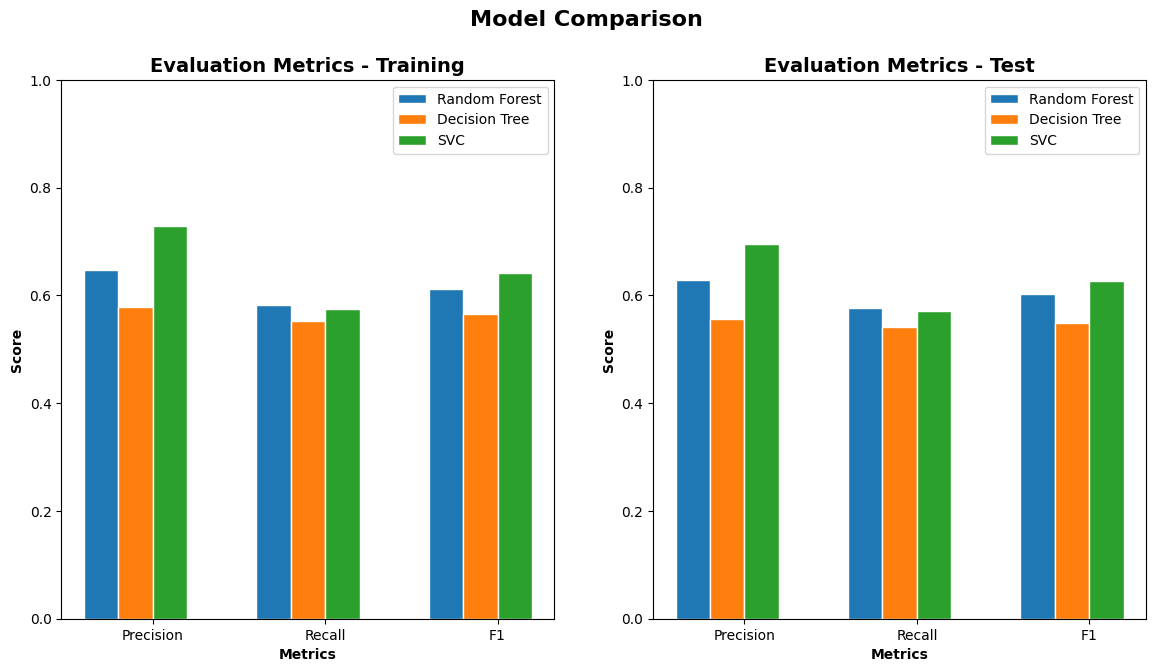

In [37]:
plot_model_comparison(rf_score_train, dt_score_train, svc_score_train, rf_score_test, dt_score_test, svc_score_test)